In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from my_multi_main4 import Net,test
from torchvision import datasets, transforms

In [5]:
model_file = 'mnist4_multi_97.2_0.0100_SGD_gfusedmax_0_1.00_0.12_2.pt'
params = model_file.strip('.pt').split('_')
_,_,acc,lr,optim_type,max_type,norm_flag,lam,gamma,head_cnt = \
    params[0],params[1],float(params[2]),float(params[3]),params[4],\
    params[5],bool(int(params[6])),float(params[7]),float(params[8]),int(params[9])
model = Net(max_type,norm_flag,lam,gamma,head_cnt)
model.load_state_dict(torch.load(model_file,map_location='cpu'))

In [6]:
model.eval()
use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', download=True, train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True, **kwargs)
test_acc = test(None, model, device, test_loader)
print(test_acc)


Test set: Average loss: 0.0929, Accuracy: 9709/10000 (97%)

0.9709


In [7]:
print(type(test_loader.dataset.test_data),test_loader.dataset.test_data.size())
test_data = test_loader.dataset.test_data

<class 'torch.Tensor'> torch.Size([10000, 28, 28])


In [18]:
import torch.nn as nn
import torch.nn.functional as F
def forward_att(att,x):
    N,C,H,W = x.size()
    x = x.reshape([N,H,W,C])
    proj_x = att.proj_func(x)
    score_x = att.score_func(x)
    scores = torch.reshape(score_x,[N,-1,1])
    projs = torch.reshape(proj_x,[N,-1,att.output_size])
    weights = att.mapping_func(att.score_norm(scores),dim=-2)
    output = torch.sum(projs * weights,dim=-2)
    return proj_x,score_x,weights.reshape(score_x.size()),output
def forward(model,x):
    print(x.size())
    h1 = F.relu(model.conv1(x))
    print(h1.size())
    h1_pooled = F.max_pool2d(h1, 2, 2)
    print(h1_pooled.size())
    h2 = F.relu(model.conv2(h1_pooled))
    # h2_pooled = F.max_pool2d(h2, 2, 2)
    att_out = torch.cat([att(h2) for att in model.attention_pool],dim=1).view(-1,500)
    h3 = F.relu(att_out)
    h4 = model.fc2(h3)
    return h1,h1_pooled,h2,att_out,h3,h4
def weight_image(weight):
    image_size = 28
    recp_size = 8
    weight_size = 11
    stride = int((image_size-recp_size)/(weight_size-1))
    
    output = np.zeros([image_size,image_size])
    for i in range(weight_size):
        for j in range(weight_size):
            output[i*stride:(i*stride+recp_size),j*stride:(j*stride+recp_size)] += weight[i,j]
    return output
def weight_on_image(weight,image):
    output = np.zeros(weight.shape+(3,))
    output[:,:,0] = image
    output[:,:,2] = weight
    return output
norm_image = lambda x: (x.type(torch.float)/255.-0.1307)/0.3081

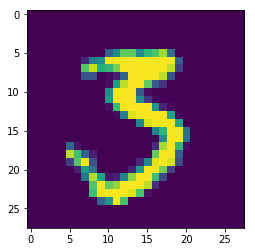

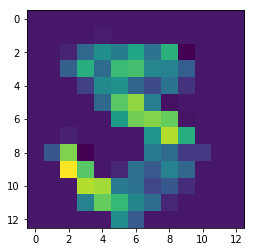

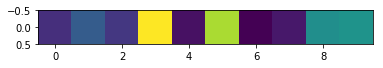

torch.Size([1, 11, 11, 250]) torch.Size([1, 11, 11, 1]) torch.Size([1, 11, 11, 1]) torch.Size([1, 250])


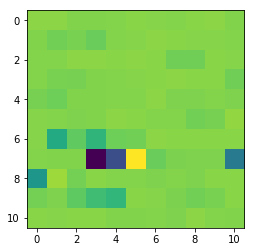

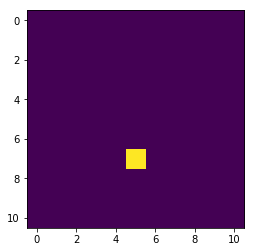

torch.Size([1, 11, 11, 250]) torch.Size([1, 11, 11, 1]) torch.Size([1, 11, 11, 1]) torch.Size([1, 250])


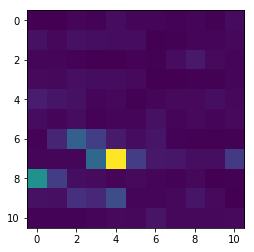

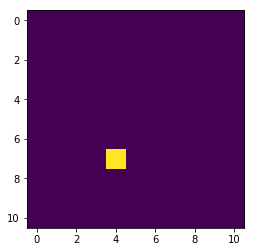

In [9]:
with torch.no_grad():
    index = np.random.choice(test_data.size()[0])
    plt.imshow(test_data[index])
    plt.show()
    h1,h1_pooled,h2,att_out,h3,h4 = forward(model,norm_image(test_data[index]).unsqueeze_(0).unsqueeze(0))
    plt.imshow(h1_pooled[0,10])
    plt.show()
    #plt.imshow(h2_pooled[0,10])
    #plt.show()
    plt.imshow(h4)
    plt.show()
    proj0,score0,weights0,att_out0 = forward_att(model.attention_pool[0],h2)
    print(proj0.shape,score0.shape,weights0.shape,att_out0.shape)
    plt.imshow(score0[0,:,:,0])
    plt.show()
    plt.imshow(weights0[0,:,:,0])
    plt.show()
    proj1,score1,weights1,att_out1 = forward_att(model.attention_pool[1],h2)
    print(proj1.shape,score1.shape,weights1.shape,att_out1.shape)
    plt.imshow(score1[0,:,:,0])
    plt.show()
    plt.imshow(weights1[0,:,:,0])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

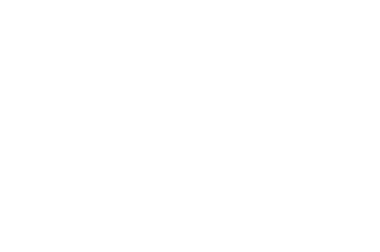

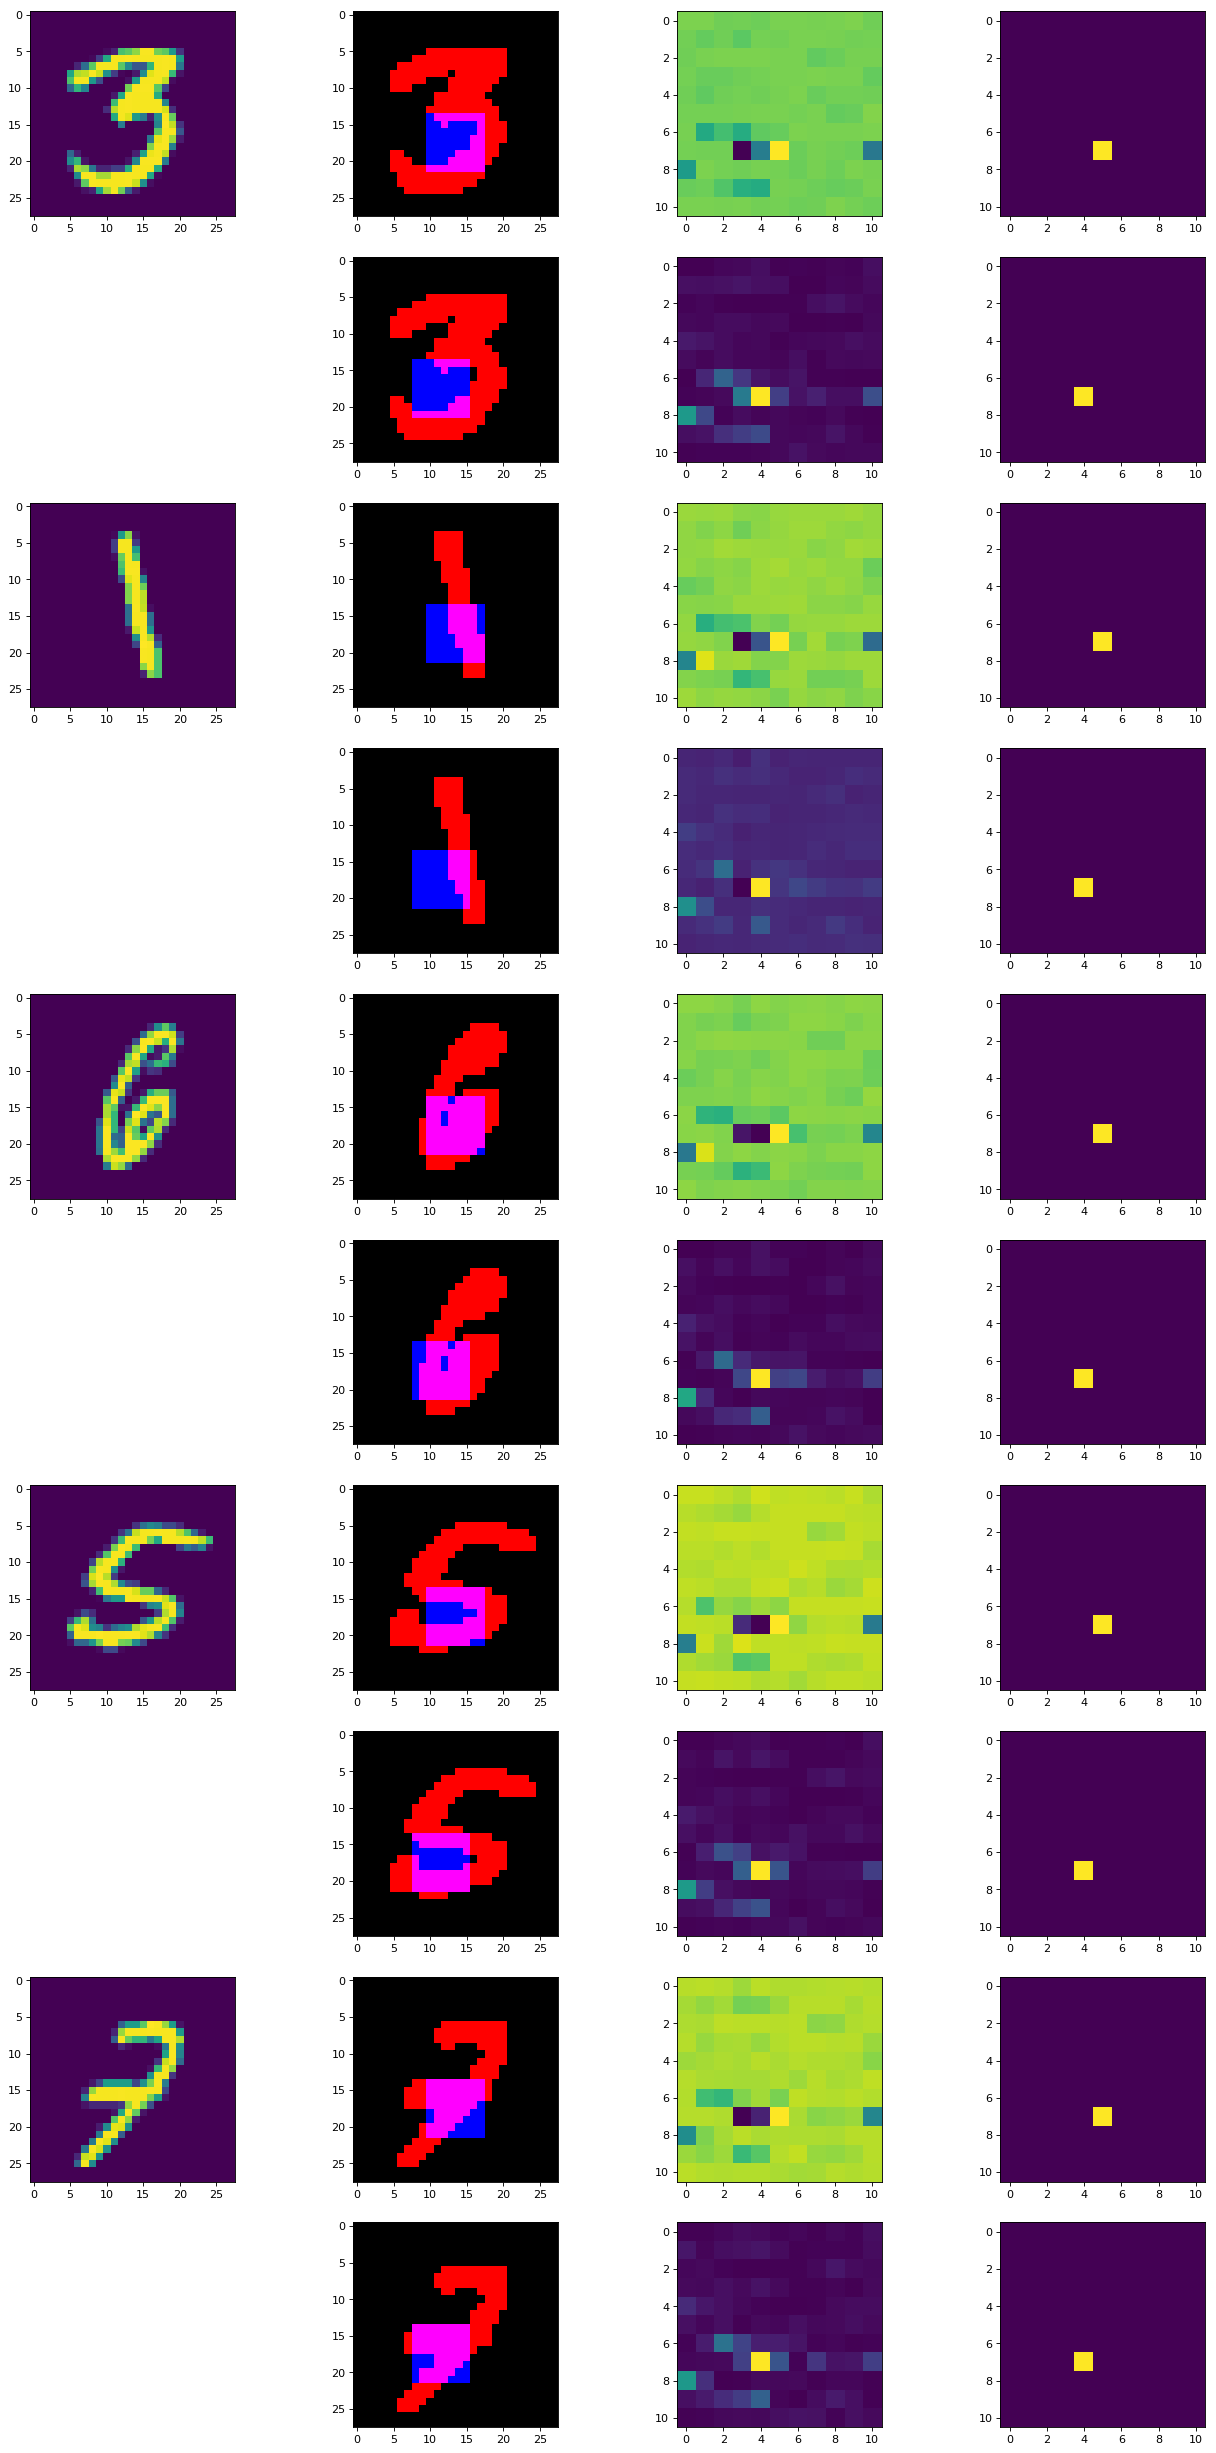

In [21]:
samples = 5
sample_per_row = 4
plt.axis('off')
fig=plt.figure(figsize=(20, 40), dpi= 80)
with torch.no_grad():
    for s in range(samples):
        index = np.random.choice(test_data.size()[0])
        h1,h1_pooled,h2,att_out,h3,h4 = forward(model,norm_image(test_data[index]).unsqueeze_(0).unsqueeze(0))
        proj0,score0,weights0,att_out0 = forward_att(model.attention_pool[0],h2)
        proj1,score1,weights1,att_out1 = forward_att(model.attention_pool[1],h2)
        image_weighted0 = weight_image(weights0[0,:,:,0].numpy()) 
        image_weighted1 = weight_image(weights1[0,:,:,0].numpy()) 
        image_with_weighted0 = weight_on_image(image_weighted0,test_data[index].numpy()) 
        image_with_weighted1 = weight_on_image(image_weighted1,test_data[index].numpy()) 
        
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+1)
        plt.imshow(test_data[index])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+2)
        plt.imshow(image_with_weighted0)
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+3)
        plt.imshow(score0[0,:,:,0])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+4)
        plt.imshow(weights0[0,:,:,0])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+6)
        plt.imshow(image_with_weighted1)
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+7)
        plt.imshow(score1[0,:,:,0])
        plt.subplot(2*np.ceil(samples*4/sample_per_row),sample_per_row,8*s+8)
        plt.imshow(weights1[0,:,:,0])
plt.show()

In [27]:
h1,h1_pooled,h2,att_out,h3,h4 = forward(model,norm_image(test_data).unsqueeze_(1))
proj0,score0,weights0,att_out0 = forward_att(model.attention_pool[0],h2)
proj1,score1,weights1,att_out1 = forward_att(model.attention_pool[1],h2)
all_weights0 = np.sum(np.abs(weights0[:,:,:,0].numpy()),axis=0)
all_weights1 = np.sum(np.abs(weights1[:,:,:,0].numpy()),axis=0)
print(all_weights0)
print(all_weights1)

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [26]:
h1.size()

torch.Size([1, 20, 26, 26])